In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import copy
import random
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from collections import defaultdict
import heapq
from tqdm import tqdm
import seaborn as sns
import warnings
import pandas as pd
import time


# Suppress warnings for cleaner logs
warnings.filterwarnings("ignore")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# FedModel
class FedModel(nn.Module):
    def __init__(self):
        super(FedModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

        self.importance_scores = {
            'conv1': 1.0,
            'conv2': 1.0,
            'fc1': 1.0,
            'fc2': 1.0
        }
        self.importance_momentum = 0.9

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

    def get_meta_gradient(self, x, y, criterion):
        self.zero_grad()
        output = self(x)
        loss = criterion(output, y)
        grad1 = torch.autograd.grad(loss, self.parameters(), create_graph=True)

        meta_grad = []
        for g in grad1:
            if g is not None:
                grad_norm = torch.norm(g)
                grad_of_grad = torch.autograd.grad(grad_norm, self.parameters(), retain_graph=True)
                meta_grad.append(
                    grad_of_grad[0].detach().cpu().numpy()
                    if grad_of_grad[0] is not None else np.zeros_like(g.detach().cpu().numpy())
                )
            else:
                meta_grad.append(np.zeros_like(g.detach().cpu().numpy()))
        return meta_grad

In [ ]:
# Non-IID split
def prepare_non_iid_data(num_clients, alpha=0.3, min_samples=100):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])

    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, transform=transform)

    client_data_indices = {i: [] for i in range(num_clients)}
    num_classes = 10

    for class_idx in range(num_classes):
        class_indices = np.where(train_dataset.targets.numpy() == class_idx)[0]
        np.random.shuffle(class_indices)

        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        splits = (np.cumsum(proportions) * len(class_indices)).astype(int)[:-1]
        class_splits = np.split(class_indices, splits)

        for client_idx in range(num_clients):
            if client_idx < len(class_splits):
                client_data_indices[client_idx].extend(class_splits[client_idx])

    client_datasets = []
    for client_idx in range(num_clients):
        indices = client_data_indices[client_idx]
        if len(indices) < min_samples:
            needed = min_samples - len(indices)
            all_indices = set(range(len(train_dataset)))
            available = list(all_indices - set(indices))
            extra_indices = np.random.choice(available, needed, replace=False)
            indices.extend(extra_indices)
        client_dataset = torch.utils.data.Subset(train_dataset, indices)
        client_datasets.append(client_dataset)

    return client_datasets, test_dataset

In [ ]:
# Cluster manager
class ClusterManager:
    def __init__(self, num_clients, num_clusters=3):
        self.num_clusters = num_clusters
        self.clusters = {i: [] for i in range(num_clusters)}
        self.cluster_models = {}
        self.task_embeddings = {}
        self.cluster_acc_history = defaultdict(list)
        self.cluster_history = []
        self.client_history = defaultdict(list)
        self.last_cluster_change = -5
        self.num_clients = num_clients

    def update_clusters(self, client_models, client_datasets, criterion, round_num):
        if round_num - self.last_cluster_change < 5 and round_num > 10:
            return

        self.task_embeddings.clear()
        valid_clients = 0

        for client_id in range(self.num_clients):
            if client_id not in client_models or client_id >= len(client_datasets) or len(client_datasets[client_id]) == 0:
                continue

            loader = torch.utils.data.DataLoader(client_datasets[client_id], batch_size=64, shuffle=True)
            x, y = next(iter(loader))
            x, y = x.to(device), y.to(device)

            try:
                meta_grad = client_models[client_id].get_meta_gradient(x, y, criterion)
                embedding = np.concatenate([g.flatten() for g in meta_grad if g is not None])
                self.task_embeddings[client_id] = embedding
                valid_clients += 1
            except Exception as e:
                print(f"[Cluster] Meta-gradient error for client {client_id}: {e}")

        if valid_clients >= self.num_clusters:
            embeddings = np.array(list(self.task_embeddings.values()))

            # Dynamic cluster selection
            if round_num % 10 == 0 or round_num < 10:
                best_score = -1
                best_k = self.num_clusters
                for k in range(2, min(10, len(embeddings))):
                    labels = KMeans(n_clusters=k, random_state=42).fit_predict(embeddings)
                    score = silhouette_score(embeddings, labels)
                    if score > best_score:
                        best_score = score
                        best_k = k
                self.num_clusters = best_k
                print(f"[Cluster] Silhouette-optimal clusters: {self.num_clusters}")
                self.last_cluster_change = round_num

            kmeans = KMeans(n_clusters=self.num_clusters, random_state=42)
            labels = kmeans.fit_predict(embeddings)

            self.clusters = {i: [] for i in range(self.num_clusters)}
            for i, cid in enumerate(self.task_embeddings.keys()):
                self.clusters[labels[i]].append(cid)
                self.client_history[cid].append(labels[i])

            self.cluster_history.append((round_num, copy.deepcopy(self.clusters)))
            self.update_cluster_models(client_models)

    def update_cluster_models(self, client_models):
        for cluster_id, client_ids in self.clusters.items():
            if not client_ids:
                continue

            base_model = client_models[client_ids[0]]
            avg_state = copy.deepcopy(base_model.state_dict())
            for key in avg_state:
                avg_state[key] = torch.zeros_like(avg_state[key])

            for client_id in client_ids:
                client_state = client_models[client_id].state_dict()
                for key in avg_state:
                    avg_state[key] += client_state[key]

            for key in avg_state:
                avg_state[key] /= len(client_ids)

            if cluster_id not in self.cluster_models:
                self.cluster_models[cluster_id] = copy.deepcopy(base_model)
            self.cluster_models[cluster_id].load_state_dict(avg_state)

In [ ]:
# Async Communication
class AsyncCommunicationManager:
    def __init__(self):
        self.client_priorities = {}
        self.staleness = {}
        self.update_queue = []
        self.accumulated_grads = defaultdict(list)
        self.selected_history = []

    def update_priority(self, client_id, data_size, gradient_norm, staleness, accuracy):
        data_importance = data_size * (gradient_norm + 1e-6)
        freshness = 1 / (1 + staleness)
        fairness = 1.0 - min(accuracy / 100.0, 1.0)
        priority = data_importance * freshness * (1 + fairness)
        self.client_priorities[client_id] = priority
        self.staleness[client_id] = staleness
        return priority

    def add_update(self, client_id, model_update, priority, round_num, sync_freq):
        self.accumulated_grads[client_id].append(model_update)
        if round_num % sync_freq == 0 or len(self.accumulated_grads[client_id]) >= sync_freq:
            avg_update = copy.deepcopy(self.accumulated_grads[client_id][0])
            state_dict = avg_update.state_dict()
            for key in state_dict:
                state_dict[key] = torch.zeros_like(state_dict[key])
                for update in self.accumulated_grads[client_id]:
                    state_dict[key] += update.state_dict()[key]
                state_dict[key] /= len(self.accumulated_grads[client_id])
            avg_update.load_state_dict(state_dict)
            heapq.heappush(self.update_queue, (-priority, client_id, avg_update))
            self.accumulated_grads[client_id] = []

    def get_updates(self, max_updates=5):
        selected_updates, selected_clients = [], []
        while len(selected_updates) < max_updates and self.update_queue:
            priority, client_id, update = heapq.heappop(self.update_queue)
            selected_updates.append(update)
            selected_clients.append(client_id)

        self.selected_history.append(selected_clients)
        return selected_updates, selected_clients

In [ ]:
# DQN network
class DQN(nn.Module):
    def __init__(self, input_size, output_size):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.out(x)

# RL optimizer
class RLOptimizer:
    def __init__(self, input_size=2, action_space=12):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.action_space = action_space
        self.model = DQN(input_size, action_space).to(self.device)
        self.target_model = DQN(input_size, action_space).to(self.device)
        self.target_model.load_state_dict(self.model.state_dict())
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

        self.replay_buffer = []
        self.gamma = 0.95
        self.epsilon = 1.0
        self.epsilon_min = 0.05
        self.epsilon_decay = 0.995
        self.batch_size = 32
        self.update_target_every = 10
        self.step = 0

        self.compression_options = [0.1, 0.2, 0.3, 0.4]
        self.sync_options = [1, 2, 3]
        self.action_history = []

    def encode_state(self, divergence, avg_accuracy):
        # Normalize based on observed ranges
        norm_div = min(divergence / 5.0, 1.0)
        norm_acc = avg_accuracy / 100.0
        return torch.tensor([norm_div, norm_acc], dtype=torch.float32).unsqueeze(0).to(self.device)

    def select_action(self, divergence, avg_accuracy):
        state = self.encode_state(divergence, avg_accuracy)
        if torch.rand(1).item() < self.epsilon:
            action_idx = torch.randint(0, self.action_space, (1,)).item()
        else:
            with torch.no_grad():
                q_values = self.model(state)
                action_idx = torch.argmax(q_values).item()

        action = self.decode_action(action_idx)
        self.action_history.append((divergence, avg_accuracy, action))
        return action, action_idx

    def decode_action(self, idx):
        comp_idx = idx // len(self.sync_options)
        sync_idx = idx % len(self.sync_options)
        return {
            'compression_rate': self.compression_options[min(comp_idx, len(self.compression_options)-1)],
            'sync_frequency': self.sync_options[min(sync_idx, len(self.sync_options)-1)]
        }

    def store(self, state, action_idx, reward, next_state):
        self.replay_buffer.append((state, action_idx, reward, next_state))
        if len(self.replay_buffer) > 5000:
            self.replay_buffer.pop(0)

    def train(self):
        if len(self.replay_buffer) < self.batch_size:
            return

        batch = random.sample(self.replay_buffer, self.batch_size)
        states, actions, rewards, next_states = zip(*batch)

        states = torch.stack(states).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).to(self.device)
        next_states = torch.stack(next_states).to(self.device)

        q_values = self.model(states)
        next_q_values = self.target_model(next_states)
        q_target = rewards + self.gamma * next_q_values.max(dim=1)[0]

        q_selected = q_values.gather(1, actions.unsqueeze(1)).squeeze()
        loss = F.mse_loss(q_selected, q_target.detach())

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        self.step += 1
        if self.step % self.update_target_every == 0:
            self.target_model.load_state_dict(self.model.state_dict())

        self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)

In [ ]:
# Gradient Compression
class GradientCompressor:
    def __init__(self, compression_rate=0.5, compression_mode="8bit"):
        self.compression_rate = max(0.1, min(0.9, compression_rate))
        self.compression_mode = compression_mode
        self.layer_importance = {
            'conv1': 0.8,
            'conv2': 0.7,
            'fc1': 0.5,
            'fc2': 0.3
        }
        self.history = []

    def compress(self, model):
        compressed_model = copy.deepcopy(model)
        state_dict = compressed_model.state_dict()

        for key in state_dict:
            if 'weight' in key or 'bias' in key:
                layer_name = key.split('.')[0]
                importance = self.layer_importance.get(layer_name, 0.5)
                rate = max(0.1, min(0.9, self.compression_rate * importance))

                tensor = state_dict[key].detach().cpu().numpy().flatten()

                # Top-K Sparsification
                k = max(1, int(rate * tensor.size))
                topk_indices = np.argpartition(np.abs(tensor), -k)[-k:]
                sparse_tensor = np.zeros_like(tensor)
                sparse_tensor[topk_indices] = tensor[topk_indices]

                # Compression Mode
                if self.compression_mode == "1bit":
                    compressed = np.sign(sparse_tensor).astype(np.int8)
                    decompressed = compressed.astype(np.float32)
                else:
                    max_val = np.max(np.abs(sparse_tensor)) + 1e-8
                    quantized = np.round((sparse_tensor / max_val) * 127).astype(np.int8)
                    decompressed = (quantized.astype(np.float32) / 127) * max_val

                state_dict[key] = torch.tensor(decompressed.reshape(state_dict[key].shape)).to(device)

        self.history.append(self.compression_rate)
        compressed_model.load_state_dict(state_dict)
        return compressed_model

In [ ]:
# FL Simulator
class FederatedLearningSimulator:
    def __init__(self, num_clients=10, num_clusters=3, num_rounds=30, warmup_rounds=10, epochs_per_client=1):
        self.num_clients = num_clients
        self.num_clusters = num_clusters
        self.num_rounds = num_rounds
        self.epochs_per_client = epochs_per_client
        self.warmup_rounds = warmup_rounds

        self.client_datasets, self.test_dataset = prepare_non_iid_data(num_clients)
        self.global_model = FedModel().to(device)
        self.client_models = {i: copy.deepcopy(self.global_model) for i in range(num_clients)}
        self.cluster_manager = ClusterManager(num_clients, num_clusters)
        self.async_manager = AsyncCommunicationManager()
        self.rl_optimizer = RLOptimizer()
        self.compressor = GradientCompressor()

        self.accuracy_history = []
        self.communication_cost = []
        self.compression_rates = []
        self.sync_frequencies = []
        self.client_accuracies = defaultdict(list)
        self.cluster_accuracies = defaultdict(list)
        self.client_dropouts = defaultdict(int)
        self.best_accuracy = 0.0
        self.best_model = None
        self.selected_clients_history = []
        self.cluster_sizes_history = []
        self.round_times = []

    def client_update(self, client_id, epochs=1):
        model = self.client_models[client_id]
        if client_id >= len(self.client_datasets) or len(self.client_datasets[client_id]) == 0:
            self.client_dropouts[client_id] += 1
            return model

        loader = torch.utils.data.DataLoader(self.client_datasets[client_id], batch_size=32, shuffle=True)
        optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
        criterion = nn.NLLLoss()

        for _ in range(epochs):
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                output = model(x)
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()

        self.update_layer_importance(model)
        return model

    def update_layer_importance(self, model):
        total_grad = 1e-6
        grad_norms = {}

        for name, param in model.named_parameters():
            if param.grad is not None:
                grad_norm = torch.norm(param.grad).item()
                layer = name.split('.')[0]
                grad_norms[layer] = grad_norms.get(layer, 0) + grad_norm
                total_grad += grad_norm

        for layer, norm in grad_norms.items():
            new_score = norm / total_grad
            model.importance_scores[layer] = (
                model.importance_momentum * model.importance_scores[layer] +
                (1 - model.importance_momentum) * new_score
            )
            self.compressor.layer_importance[layer] = model.importance_scores[layer]

    def evaluate(self, model, dataset=None):
        if dataset is None:
            dataset = self.test_dataset
        model.eval()
        correct = 0
        loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=False)
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                output = model(x)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(y.view_as(pred)).sum().item()
        accuracy = 100. * correct / len(dataset)
        return accuracy

    def run(self):
        criterion = nn.NLLLoss()
        selected_clients = []

        print("Starting Federated Learning Training...")
        print(f"{'Round':<6} {'Accuracy':<10} {'Comm Cost':<12} {'Comp Rate':<10} {'Sync Freq':<10} {'Clusters':<10}")
        print("-" * 70)

        for round_num in tqdm(range(self.num_rounds), desc="FL Training"):
            round_start = time.time()
            is_warmup = round_num < self.warmup_rounds
            divergence = 0.0

            if is_warmup:
                compression_rate = 0.5
                sync_freq = 2
            else:
                stds = [np.std(v) for v in self.client_accuracies.values() if len(v) > 1]
                divergence = np.mean(stds) if stds else 0.0
                accuracies = [v[-1] for v in self.client_accuracies.values() if len(v) > 0]
                avg_accuracy = np.mean(accuracies) if accuracies else 0.0
                rl_action, action_idx = self.rl_optimizer.select_action(divergence, avg_accuracy)
                compression_rate = rl_action['compression_rate']
                sync_freq = rl_action['sync_frequency']

            # Smooth compression rate changes
            if self.compression_rates:
                smoothed_rate = 0.7 * self.compression_rates[-1] + 0.3 * compression_rate
            else:
                smoothed_rate = compression_rate

            self.compressor.compression_rate = smoothed_rate
            self.compression_rates.append(smoothed_rate)
            self.sync_frequencies.append(sync_freq)

            # Client updates
            for client_id in range(self.num_clients):
                model = self.client_update(client_id, self.epochs_per_client)
                dataset = self.client_datasets[client_id]

                if len(dataset) > 0:
                    loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)
                    x, y = next(iter(loader))
                    x, y = x.to(device), y.to(device)

                    output = model(x)
                    grad_norm = torch.norm(torch.cat([p.grad.flatten() for p in model.parameters() if p.grad is not None]))

                    acc = self.evaluate(model, dataset)
                    self.client_accuracies[client_id].append(acc)

                    stale = self.async_manager.staleness.get(client_id, 0)
                    priority = self.async_manager.update_priority(client_id, len(dataset), grad_norm.item(), stale, acc)

                    compressed = self.compressor.compress(model)
                    self.async_manager.add_update(client_id, compressed, priority, round_num, sync_freq)
                    self.async_manager.staleness[client_id] = stale + 1

            # Global aggregation
            if round_num % max(1, sync_freq) == 0:
                updates, selected_clients = self.async_manager.get_updates(max_updates=5)
                self.selected_clients_history.append((round_num, selected_clients))

                if updates:
                    global_state = self.global_model.state_dict()
                    for key in global_state:
                        global_state[key] = torch.stack([u.state_dict()[key] for u in updates]).mean(0)
                        global_state[key] = 0.9 * self.global_model.state_dict()[key] + 0.1 * global_state[key]
                    self.global_model.load_state_dict(global_state)

                    for cid in selected_clients:
                        self.client_models[cid] = copy.deepcopy(self.global_model)
                        self.async_manager.staleness[cid] = 0

            # Cluster updates
            if round_num % 3 == 0:
                self.cluster_manager.update_clusters(self.client_models, self.client_datasets, criterion, round_num)

            # Track cluster sizes
            cluster_sizes = {cid: len(clients) for cid, clients in self.cluster_manager.clusters.items()}
            self.cluster_sizes_history.append((round_num, cluster_sizes))

            # Cluster model evaluation
            for cid, cluster_model in self.cluster_manager.cluster_models.items():
                acc = self.evaluate(cluster_model, self.test_dataset)
                self.cluster_accuracies[cid].append(acc)
                if cid in self.cluster_manager.clusters:
                    for client_id in self.cluster_manager.clusters[cid]:
                        self.client_models[client_id] = copy.deepcopy(cluster_model)

            # Global evaluation
            acc = self.evaluate(self.global_model)
            self.accuracy_history.append(acc)
            if acc > self.best_accuracy:
                self.best_accuracy = acc
                self.best_model = copy.deepcopy(self.global_model)
                torch.save(self.best_model.state_dict(), "best_model.pth")

            # Communication cost calculation
            cost = sum(p.numel() for p in self.global_model.parameters()) * len(selected_clients) * smoothed_rate
            self.communication_cost.append(cost)

            # RL training (after warmup)
            if not is_warmup:
                final_accs = [self.client_accuracies[c][-1] for c in selected_clients if len(self.client_accuracies[c]) > 0]
                fairness = 1.0 - np.std(final_accs) if len(final_accs) > 1 else 1.0
                alpha = 0.005 * (1 + round_num / self.num_rounds)
                reward = acc + 0.5 * fairness - alpha * cost + 0.1 * len(selected_clients)
                state = self.rl_optimizer.encode_state(divergence, avg_accuracy)
                next_state = state
                self.rl_optimizer.store(state, action_idx, reward, next_state)
                self.rl_optimizer.train()

            # Round time tracking
            round_time = time.time() - round_start
            self.round_times.append(round_time)

            # Print progress
            print(f"{round_num:<6} {acc:<10.2f} {cost:<12.2f} {smoothed_rate:<10.2f} {sync_freq:<10} {len(self.cluster_manager.clusters):<10}")

        print("\nTraining Complete!")
        print(f"Best Accuracy Achieved: {self.best_accuracy:.2f}%")

    def visualize_results(self):
        plt.figure(figsize=(12, 5))

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(self.accuracy_history, label='Global Accuracy', color='blue')
        plt.xlabel('Rounds')
        plt.ylabel('Accuracy (%)')
        plt.title('Model Accuracy Over Rounds')
        plt.grid(True)

        # Communication Cost
        plt.subplot(1, 2, 2)
        plt.plot(self.communication_cost, label='Communication Cost', color='orange')
        plt.xlabel('Rounds')
        plt.ylabel('Communication Cost')
        plt.title('Communication Cost Over Rounds')
        plt.grid(True)

100%|██████████| 9.91M/9.91M [00:00<00:00, 15.9MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 489kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.45MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.85MB/s]


Starting Federated Learning Training...
Round  Accuracy   Comm Cost    Comp Rate  Sync Freq  Clusters  
----------------------------------------------------------------------


FL Training:   0%|          | 0/30 [00:00<?, ?it/s]

[Cluster] Silhouette-optimal clusters: 2


FL Training:   3%|▎         | 1/30 [00:38<18:42, 38.72s/it]

0      44.23      2999705.00   0.50       2          2         


FL Training:   7%|▋         | 2/30 [01:15<17:38, 37.80s/it]

1      44.23      2999705.00   0.50       2          2         


FL Training:  10%|█         | 3/30 [01:51<16:38, 36.97s/it]

2      72.04      2999705.00   0.50       2          2         
[Cluster] Silhouette-optimal clusters: 2


FL Training:  13%|█▎        | 4/30 [02:28<15:55, 36.74s/it]

3      72.04      2999705.00   0.50       2          2         


FL Training:  17%|█▋        | 5/30 [03:04<15:09, 36.40s/it]

4      79.24      2999705.00   0.50       2          2         


FL Training:  20%|██        | 6/30 [03:39<14:26, 36.09s/it]

5      79.24      2999705.00   0.50       2          2         
[Cluster] Silhouette-optimal clusters: 4


FL Training:  23%|██▎       | 7/30 [04:19<14:20, 37.41s/it]

6      85.89      2999705.00   0.50       2          4         


FL Training:  27%|██▋       | 8/30 [04:59<13:58, 38.13s/it]

7      85.89      2999705.00   0.50       2          4         


FL Training:  30%|███       | 9/30 [05:39<13:32, 38.70s/it]

8      89.36      2999705.00   0.50       2          4         
[Cluster] Silhouette-optimal clusters: 2


FL Training:  33%|███▎      | 10/30 [06:19<13:04, 39.21s/it]

9      89.36      2999705.00   0.50       2          2         


FL Training:  37%|███▋      | 11/30 [06:58<12:25, 39.23s/it]

10     89.36      2639740.40   0.44       3          2         


FL Training:  40%|████      | 12/30 [07:38<11:47, 39.31s/it]

11     89.36      2387765.18   0.40       2          2         


FL Training:  43%|████▎     | 13/30 [08:18<11:12, 39.56s/it]

12     91.44      2391364.83   0.40       2          2         


FL Training:  47%|████▋     | 14/30 [08:57<10:31, 39.48s/it]

13     91.44      1853937.68   0.31       3          2         


FL Training:  50%|█████     | 15/30 [09:37<09:54, 39.60s/it]

14     93.14      1657720.97   0.28       2          2         


FL Training:  53%|█████▎    | 16/30 [10:17<09:17, 39.79s/it]

15     93.14      1340386.98   0.22       2          2         


FL Training:  57%|█████▋    | 17/30 [11:04<09:04, 41.89s/it]

16     93.77      1478217.79   0.25       1          2         


FL Training:  60%|██████    | 18/30 [11:48<08:28, 42.41s/it]

17     93.77      1574699.35   0.26       3          2         


FL Training:  63%|██████▎   | 19/30 [12:39<08:14, 44.93s/it]

18     93.81      1282271.85   0.21       2          2         


FL Training:  67%|██████▋   | 20/30 [13:23<07:28, 44.87s/it]

19     94.49      1257554.89   0.21       1          2         


FL Training:  70%|███████   | 21/30 [14:15<07:02, 46.95s/it]

20     95.13      1420235.32   0.24       2          2         


FL Training:  73%|███████▎  | 22/30 [14:59<06:08, 46.05s/it]

21     95.59      1714093.93   0.29       1          2         


FL Training:  77%|███████▋  | 23/30 [15:39<05:09, 44.27s/it]

22     95.59      1919794.95   0.32       3          2         


FL Training:  80%|████████  | 24/30 [16:20<04:19, 43.25s/it]

23     95.62      1703821.06   0.28       1          2         


FL Training:  83%|████████▎ | 25/30 [17:01<03:32, 42.42s/it]

24     95.72      1732621.65   0.29       3          2         


FL Training:  87%|████████▋ | 26/30 [17:40<02:46, 41.61s/it]

25     95.72      1752782.05   0.29       3          2         


FL Training:  90%|█████████ | 27/30 [18:21<02:03, 41.20s/it]

26     95.72      1406929.74   0.23       3          2         


FL Training:  93%|█████████▎| 28/30 [19:01<01:21, 40.84s/it]

27     95.93      1344815.42   0.22       1          2         


FL Training:  97%|█████████▋| 29/30 [19:40<00:40, 40.46s/it]

28     95.93      1121353.09   0.19       3          2         


FL Training: 100%|██████████| 30/30 [20:20<00:00, 40.68s/it]

29     96.00      1504876.36   0.25       1          2         

Training Complete!
Best Accuracy Achieved: 96.00%

Total execution time: 20.41 minutes


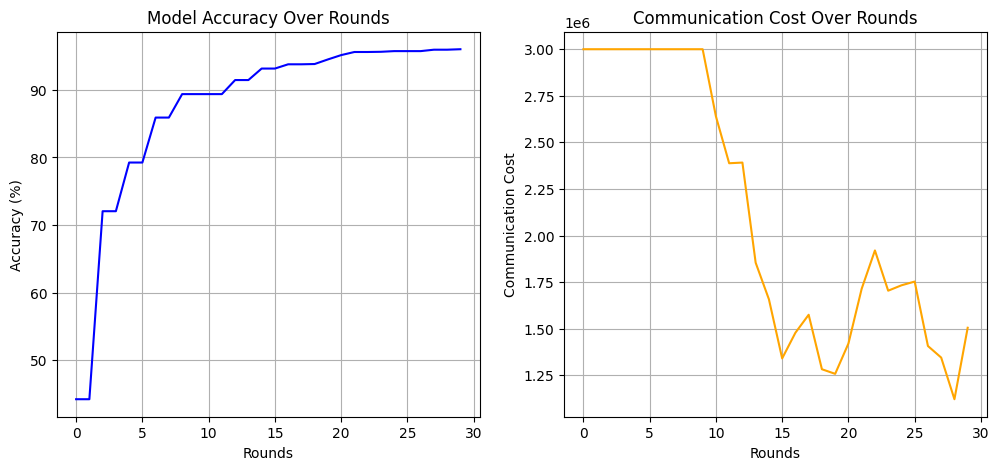

In [ ]:
# Main
if __name__ == "__main__":
    start_time = time.time()

    simulator = FederatedLearningSimulator(
        num_clients=10,
        num_clusters=3,
        num_rounds=30,
        warmup_rounds=10,
        epochs_per_client=1
    )
    simulator.run()
    simulator.visualize_results()
    torch.save(simulator.best_model.state_dict(), "final_model.pth")

    print(f"\nTotal execution time: {(time.time() - start_time)/60:.2f} minutes")

In [ ]:
#FedAvg + Clustering

class FedAvgSimulator:
    def __init__(self, num_clients=10, num_rounds=30, epochs_per_client=1, num_clusters=3, cluster_every=5):
        self.num_clients = num_clients
        self.num_rounds = num_rounds
        self.epochs_per_client = epochs_per_client
        self.num_clusters = num_clusters
        self.cluster_every = cluster_every
        self.client_datasets, self.test_dataset = prepare_non_iid_data(num_clients)
        self.global_model = FedModel().to(device)
        self.communication_cost = []
        self.accuracy_history = []
        self.best_accuracy = 0.0
        self.clusters = {i: list(range(num_clients)) for i in range(self.num_clusters)}

    def client_update(self, model, dataset, epochs):
        local_model = copy.deepcopy(model)
        optimizer = optim.SGD(local_model.parameters(), lr=0.01, momentum=0.9)
        criterion = nn.NLLLoss()
        loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
        local_model.train()
        for _ in range(epochs):
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                output = local_model(x)
                loss = criterion(output, y)
                loss.backward()
                optimizer.step()
        return local_model.state_dict()

    def evaluate(self):
        self.global_model.eval()
        correct = 0
        loader = torch.utils.data.DataLoader(self.test_dataset, batch_size=64, shuffle=False)
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                output = self.global_model(x)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(y.view_as(pred)).sum().item()
        return 100. * correct / len(self.test_dataset)

    def extract_embeddings(self, models):
        embeddings = []
        for state_dict in models:
            flat = torch.cat([v.view(-1) for v in state_dict.values()])
            embeddings.append(flat.cpu().numpy())
        return np.array(embeddings)

    def cluster_clients(self, client_models):
        embeddings = self.extract_embeddings(client_models)
        kmeans = KMeans(n_clusters=self.num_clusters, random_state=42)
        labels = kmeans.fit_predict(embeddings)
        clusters = {i: [] for i in range(self.num_clusters)}
        for cid, label in enumerate(labels):
            clusters[label].append(cid)
        return clusters

    def run(self):
        print("\nStarting FedAvg + Clustering Training...")
        print(f"{'Round':<6} {'Accuracy':<10} {'Comm Cost':<12}")
        print("-" * 40)

        for round_num in range(self.num_rounds):
            client_updates = []
            for cid in range(self.num_clients):
                update = self.client_update(self.global_model, self.client_datasets[cid], self.epochs_per_client)
                client_updates.append(update)

            # Re-cluster clients every few rounds
            if round_num % self.cluster_every == 0 or round_num == 0:
                self.clusters = self.cluster_clients(client_updates)
                print(f"[Clustering] Round {round_num}: {self.clusters}")

            # Per-cluster aggregation
            aggregated_state = {k: torch.zeros_like(v) for k, v in self.global_model.state_dict().items()}
            for cluster_id, client_ids in self.clusters.items():
                if not client_ids:
                    continue
                cluster_models = [client_updates[cid] for cid in client_ids]
                for key in aggregated_state:
                    aggregated_state[key] += torch.stack([model[key] for model in cluster_models]).mean(0)
            # Final aggregation across clusters
            for key in aggregated_state:
                aggregated_state[key] /= max(1, self.num_clusters)

            self.global_model.load_state_dict(aggregated_state)

            acc = self.evaluate()
            cost = sum(p.numel() for p in self.global_model.parameters()) * self.num_clients
            self.accuracy_history.append(acc)
            self.communication_cost.append(cost)

            self.best_accuracy = max(self.best_accuracy, acc)
            print(f"{round_num:<6} {acc:<10.2f} {cost:<12}")

        print("Training Complete. Best Accuracy: %.2f%%" % self.best_accuracy)


In [ ]:
if __name__ == "__main__":
    fedavg_sim = FedAvgSimulator()
    fedavg_sim.run()


Starting FedAvg + Clustering Training...
Round  Accuracy   Comm Cost   
----------------------------------------
[Clustering] Round 0: {0: [3], 1: [1, 2, 4, 5, 6, 7, 8, 9], 2: [0]}
0      79.14      11998820    
1      92.48      11998820    
2      95.31      11998820    
3      95.97      11998820    
4      96.48      11998820    
[Clustering] Round 5: {0: [3], 1: [1, 2, 4, 5, 6, 7, 8, 9], 2: [0]}
5      96.46      11998820    
6      97.29      11998820    
7      97.32      11998820    
8      97.61      11998820    
9      97.78      11998820    
[Clustering] Round 10: {0: [3], 1: [0, 2, 4, 5, 6, 7, 8, 9], 2: [1]}
10     97.97      11998820    
11     98.16      11998820    
12     98.02      11998820    
13     98.08      11998820    
14     98.16      11998820    
[Clustering] Round 15: {0: [1, 2, 3, 4, 5, 7, 8, 9], 1: [6], 2: [0]}
15     97.91      11998820    
16     98.34      11998820    
17     97.85      11998820    
18     98.21      11998820    
19     98.15      11998

In [ ]:
#FedProx + Asynchronous Communication

class FedProxAsyncSimulator:
    def __init__(self, num_clients=10, num_rounds=30, epochs_per_client=1, mu=0.01,
                 sync_frequency=2, max_async_clients=5):
        self.num_clients = num_clients
        self.num_rounds = num_rounds
        self.epochs_per_client = epochs_per_client
        self.mu = mu
        self.sync_frequency = sync_frequency
        self.max_async_clients = max_async_clients

        self.client_datasets, self.test_dataset = prepare_non_iid_data(num_clients)
        self.global_model = FedModel().to(device)
        self.client_models = [copy.deepcopy(self.global_model) for _ in range(num_clients)]

        self.staleness = defaultdict(int)
        self.update_queue = []
        self.communication_cost = []
        self.accuracy_history = []
        self.best_accuracy = 0.0

    def client_update(self, cid):
        local_model = copy.deepcopy(self.client_models[cid])
        optimizer = optim.SGD(local_model.parameters(), lr=0.01, momentum=0.9)
        criterion = nn.NLLLoss()
        dataset = self.client_datasets[cid]
        loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
        global_weights = self.global_model.state_dict()

        local_model.train()
        for _ in range(self.epochs_per_client):
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                output = local_model(x)
                loss = criterion(output, y)

                prox_term = sum(((param - global_weights[name].to(device)) ** 2).sum()
                                for name, param in local_model.named_parameters())
                loss += (self.mu / 2) * prox_term

                loss.backward()
                optimizer.step()

        return local_model.state_dict()

    def evaluate(self):
        self.global_model.eval()
        correct = 0
        loader = torch.utils.data.DataLoader(self.test_dataset, batch_size=64, shuffle=False)
        with torch.no_grad():
            for x, y in loader:
                x, y = x.to(device), y.to(device)
                output = self.global_model(x)
                pred = output.argmax(dim=1, keepdim=True)
                correct += pred.eq(y.view_as(pred)).sum().item()
        return 100. * correct / len(self.test_dataset)

    def run(self):
        print("\nStarting FedProx + Asynchronous Communication...")
        print(f"{'Round':<6} {'Accuracy':<10} {'Comm Cost':<12}")
        print("-" * 40)

        for round_num in range(self.num_rounds):
            # Clients sync based on sync_frequency or staleness
            for cid in range(self.num_clients):
                if round_num % self.sync_frequency == 0 or self.staleness[cid] >= self.sync_frequency:
                    update = self.client_update(cid)
                    divergence = sum(((update[k] - self.global_model.state_dict()[k]) ** 2).sum()
                                     for k in update)
                    priority = -divergence.item() / (1 + self.staleness[cid])
                    heapq.heappush(self.update_queue, (priority, cid, update))
                    self.staleness[cid] = 0
                else:
                    self.staleness[cid] += 1

            # Select top updates
            selected_updates = []
            selected_clients = []
            while self.update_queue and len(selected_updates) < self.max_async_clients:
                _, cid, update = heapq.heappop(self.update_queue)
                selected_updates.append(update)
                selected_clients.append(cid)

            # Global model update
            if selected_updates:
                global_state = self.global_model.state_dict()
                for key in global_state:
                    global_state[key] = torch.stack([u[key] for u in selected_updates]).mean(0)
                self.global_model.load_state_dict(global_state)

                # Sync all client models to new global
                for cid in range(self.num_clients):
                    self.client_models[cid].load_state_dict(self.global_model.state_dict())

            # Evaluation
            acc = self.evaluate()
            cost = sum(p.numel() for p in self.global_model.parameters()) * len(selected_clients)
            self.accuracy_history.append(acc)
            self.communication_cost.append(cost)
            self.best_accuracy = max(self.best_accuracy, acc)

            print(f"{round_num:<6} {acc:<10.2f} {cost:<12}")

        print("Training Complete. Best Accuracy: %.2f%%" % self.best_accuracy)


In [ ]:
if __name__ == "__main__":
    fedprox_sim = FedProxAsyncSimulator()
    fedprox_sim.run()


Starting FedProx + Asynchronous Communication...
Round  Accuracy   Comm Cost   
----------------------------------------
0      87.61      5999410     
1      80.42      5999410     
2      89.03      5999410     
3      91.55      5999410     
4      93.96      5999410     
5      94.66      5999410     
6      95.67      5999410     
7      95.67      5999410     
8      96.51      5999410     
9      96.01      5999410     
10     96.27      5999410     
11     96.72      5999410     
12     97.22      5999410     
13     97.26      5999410     
14     96.81      5999410     
15     97.14      5999410     
16     97.68      5999410     
17     97.31      5999410     
18     96.98      5999410     
19     97.12      5999410     
20     97.33      5999410     
21     97.63      5999410     
22     97.79      5999410     
23     97.35      5999410     
24     97.97      5999410     
25     97.63      5999410     
26     98.05      5999410     
27     97.71      5999410     
28     97.

In [ ]:
#plots

def compare_all_methods(simulators):
    plt.figure(figsize=(16, 6))

    colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
    markers = ['o', 's', '^']

    # Accuracy
    plt.subplot(1, 2, 1)
    for idx, (label, sim) in enumerate(simulators.items()):
        plt.plot(sim.accuracy_history,
                 label=f"{label} (Best: {max(sim.accuracy_history):.2f}%)",
                 marker=markers[idx % len(markers)],
                 markevery=5,
                 markersize=6,
                 linewidth=2,
                 color=colors[idx % len(colors)])
    plt.title("Test Accuracy Across Rounds", fontsize=16, weight='bold')
    plt.xlabel("Rounds", fontsize=14)
    plt.ylabel("Accuracy (%)", fontsize=14)
    plt.legend(loc='lower right', fontsize=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

    # Communication Cost
    plt.subplot(1, 2, 2)
    for idx, (label, sim) in enumerate(simulators.items()):
        plt.plot(sim.communication_cost,
                 label=label,
                 marker=markers[idx % len(markers)],
                 markevery=5,
                 markersize=6,
                 linewidth=2,
                 color=colors[idx % len(colors)])
    plt.title("Communication Cost Per Round", fontsize=16, weight='bold')
    plt.xlabel("Rounds", fontsize=14)
    plt.ylabel("Communication Cost", fontsize=14)
    plt.legend(loc='upper right', fontsize=10)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)

    plt.tight_layout(pad=2)
    plt.show()


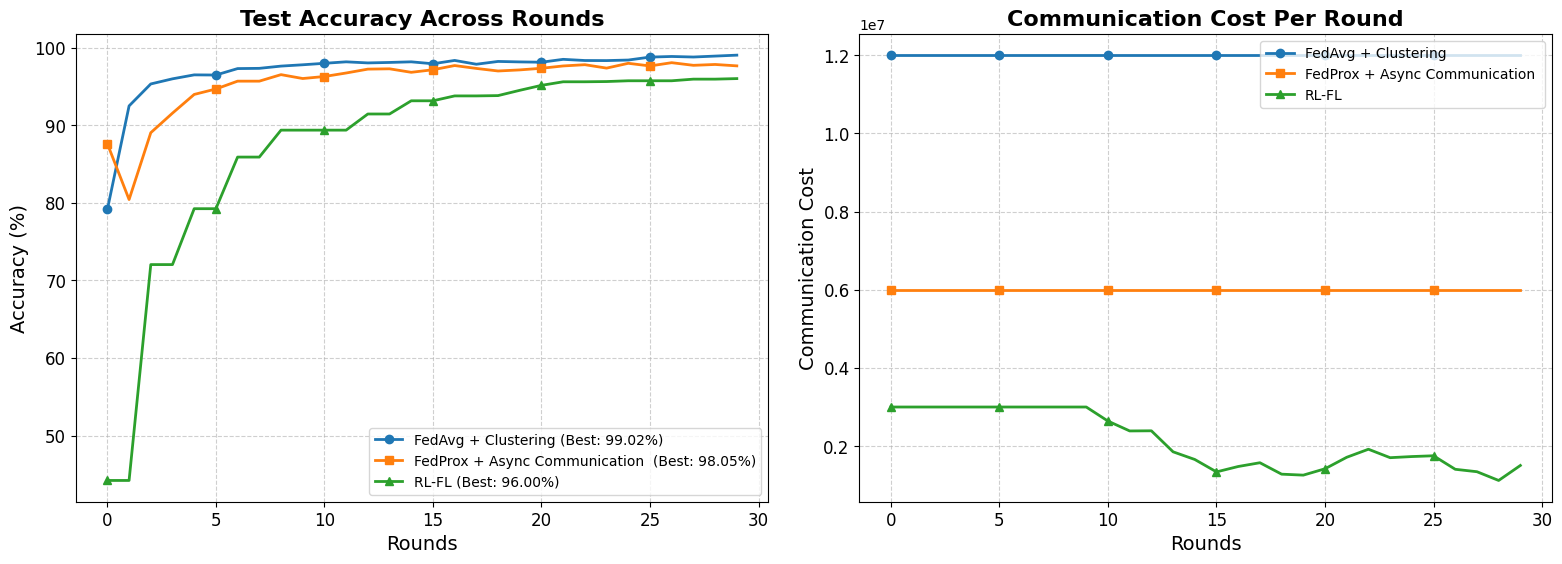

In [ ]:
if __name__ == "__main__":
    compare_all_methods({
        "FedAvg + Clustering": fedavg_sim,
        "FedProx + Async Communication ": fedprox_sim,
        "RL-FL": simulator
    })